In [3]:
import datetime
import s3fs
fs = s3fs.S3FileSystem(anon = True)

import os
import xarray as xr
import metpy
import cartopy.crs as ccrs
from pyresample import geometry, grid
import numpy as np
import matplotlib.pyplot as plt

/sharedData2/nshakoor/.conda/envs/wildfireenv3/lib/python3.8/site-packages/pyresample/bilinear/__init__.py:50: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


Using Anaconda Cloud api site https://api.anaconda.org
Fetching package metadata ...^C


# Get File Links

In [9]:
def AWSname(year, jday, utchr, band):
    """
    appends to file for using wget -i with
    puts the links for the first file for a given band at a given hour into goescodes.txt
    band should be two digits
    all inputs are strings
    """
    urls = open("../../GOES_Files/AWSurls.txt", "a")
    time_log = open("../../GOES_Files/time_log.txt", "a")
    prefix = 'https://noaa-goes17.s3.amazonaws.com/'
    file_list = fs.ls('s3://noaa-goes17/ABI-L1b-RadC/' + year + '/' + jday + '/' + utchr)
    date = datetime.datetime.strptime(year[2:] + jday, '%y%j').date()
    date = date.strftime('%m/%d/%Y')
    for file in file_list:
        if file[56:58] == band:
            file = prefix + file[12:]
            urls.write('\n' + file)
            time_log.write('\n' + date + ' UTC ' + utchr + ' band ' + band)
            break
    urls.close()
    time_log.close()
    
def writeAWSURLs(hr_0, day_0, yr, band, hr_f=None, day_f=None):
    """
    appends to file for using wget -i with
    uses a range of hours and days
    takes the first file in each hour
    all inputs are strings
    """
    if hr_f == None:
        hr_f = hr_0
    if day_f == None:
        day_f = day_0
        
    hr = int(hr_0)
    day = int(day_0)
    
    while day <= int(day_f):
        while hr <= int(hr_f):
            AWSname(yr, str(day), str(hr), band)
            hr += 1
        day += 1
        hr = int(hr_0)

In [21]:
open("../../GOES_Files/AWSurls.txt", "w").close()
writeAWSURLs('18','321','2018','14','20','323')

# Save as .npy

In [12]:
pc = ccrs.PlateCarree()
pc_extents = [-124.25, -114.25, 32.25, 42.25]
pc_params = pc.proj4_params
target_extents = [pc_extents[0],
                    pc_extents[2],
                    pc_extents[1],
                    pc_extents[3]]
target_rows = 500
target_cols = 500
shape = [target_rows, target_cols]

In [22]:
for file in os.listdir('../../GOES_Files/nc_files/'):
    try:
        data = xr.open_dataset('../../GOES_Files/nc_files/' + file)
        dat = data.metpy.parse_cf('Rad')
        geos = dat.metpy.cartopy_crs
        rad = dat.data
        
        fk1 = float(data.metpy.parse_cf('planck_fk1'))
        fk2 = float(data.metpy.parse_cf('planck_fk2'))
        bc1 = float(data.metpy.parse_cf('planck_bc1'))
        bc2 = float(data.metpy.parse_cf('planck_bc2'))
        bt = (fk2/(xr.ufuncs.log(fk1/rad + 1)) - bc1)/bc2
        bt = np.asarray(bt)

        goes_params = geos.proj4_params
        
        source_area = geometry.AreaDefinition.from_cf(data)
        target_area = geometry.AreaDefinition.from_extent('CA', pc_params, shape, target_extents)
        
        result = grid.get_resampled_image(target_area, source_area, bt)
        np.save('../../GOES_Files/npy_files/' + file[:-3], result)
        data.close()
        os.remove('../../GOES_Files/nc_files/' + file)
        
    except:
        print(file)

.ipynb_checkpoints


/sharedData2/nshakoor/.conda/envs/wildfireenv3/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/sharedData2/nshakoor/.conda/envs/wildfireenv3/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()
/sharedData2/nshakoor/.conda/envs/wildfireenv3/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-

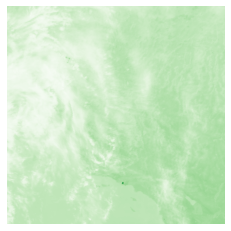

In [16]:
img_array = np.load("../../GOES_Files/npy_files/OR_ABI-L1b-RadC-M3C07_G17_s20183171802219_e20183171805003_c20183171805037.npy")
plt.imshow(img_array, aspect='equal', cmap='Greens')
plt.axis('off')
plt.show()